In [9]:
# ---------CASO C2: Vuelo rectilíneo y simétrico: T cte y V variable y pequeña -----------
#---------- aproximación por Taylor
import numpy as np
import pysindy as ps
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt
from math import pi

import utils
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from mpl_toolkits.mplot3d import Axes3D

## Ecuaciones

Lo que sindy en realidad está viendo:
$$
U_\infty \hat{\dot{V}} = -AU_\infty^2\hat{V}^2 + C - \frac{B}{\hat{V}^2*U_\infty^2}\\
\hat{\dot{V}} = -AU_\infty\hat{V}^2 + \frac{C}{U_\infty} - \frac{B}{\hat{V}^2*U_\infty^3}\\
A = \frac{1}{2} \rho_{aire} \frac{S}{m} C_{D0} \\
B = k \frac{g^2}{\frac{1}{2} \rho_{aire} \frac{S}{m}}\\
C = \frac{T}{m} \\
Sindy\hspace{0.1cm} calcula:
a = AU_\infty \\
b = \frac{B}{U_\infty^3}\\
c = \frac{C}{U_\infty}\\
\hat{\dot{V}} = -a\hat{V}^2 + c - \frac{b}{\hat{V}^2}\\
$$


## Variables globales

In [10]:
# definicion de parametros fisicos y aerondinamicos de la aeronave:
# tomado de http://www.aero.us.es/iia/archivos/Problemas/Problemas_MV.pdf
m = 200
W = m*9.81
vx0 = 10
S = 14.7
cd0 = 0.03
k = 0.073
vmax = 6

A = 0.5*1.225*cd0*S/m*10
B = k*9.81**2/(0.5*1.225*S/m)
#Empuje inicial, en este caso va a ser el mismo en todos los tiempos por ser cte
T0 = 7
print(f"Valor real de los coeficientes: A={A}, B={B}, C=T0={T0}")

Valor real de los coeficientes: A=0.013505625, B=156.0513186172428, C=T0=7


In [11]:
#definición de las variables generales
n = 100000
deltat = 0.0001
""" t = np.zeros(n)
for i in range(0, n):
    t[i] = deltat*i

print(t.shape[0], t) """
t = np.arange(0, int(n*deltat), deltat)

N_SIMS = 15


In [12]:
def initial_vars(lib=ps.PolynomialLibrary(degree=3)):   
    data = [np.ones((n, 1)), np.ones((n, 1))]
    
    lib = lib.fit(data[0])
    n_features = lib.n_output_features_
    list_names = lib.get_feature_names(['v'])
    #print(list_names)
    return n_features, data, list_names

In [13]:
def restri(rhs=-0.11):
    n_features, data, list_names = initial_vars()

    # Set constraints
    n_targets = data[1].shape[1]
    
    constraint_rhs = np.array([rhs]) #, -B/maxi[0]

    # One row per constraint, one column per coefficient
    constraint_lhs = np.zeros((1, n_targets * n_features))

    constraint_lhs[0, list_names.index('v')] = 1

    return constraint_lhs, constraint_rhs


## Funciones

In [14]:
def plot_ntraj(n_trayec, error):
    plt.figure(figsize=(8,6))
    plt.title("Análisis número de trayectorias")
    plt.xlabel('Número de trayectorias')
    plt.ylabel('Error medio de cada simulación por trayectoria')
    error2 = np.mean(error, axis=2)
    plt.semilogy(n_trayec, np.median(error2, axis=0))
    #plt.semilogy(n_trayec, np.median(np.median(error, axis=2), axis=0))
    

In [15]:
def plot_error_vs_tiempo(t, error, trayecs):
    plt.figure(figsize=(8,6))
    plt.title("Evolución error a lo largo de la trayectoria")
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Mediana del error')

    for i, n in enumerate(trayecs):
        plt.plot(t, np.median(error[:, i, :], axis=0), label=str(n) + ' trayec')
    plt.legend()

In [16]:
def plot_error_vs_tiempo_val(t, error, n_trayec):
    plt.figure(figsize=(8,6))
    plt.title("Evolución error a lo largo de la trayectoria medio")
    plt.xlabel('Tiempo de validacion(s)')
    plt.ylabel('Mediana del error')
    error2 = np.median(error, axis=0)
    for trayec, i in zip(n_trayec, range(len(n_trayec))):
        #print(len(np.median(error, axis=0).squeeze()))
        plt.semilogy(t, error2[i, :], label=str(trayec)+ ' trayec')
    plt.legend()

In [17]:
def plot_error_vs_pot_ruido(error, n_trayec, pots):
    plt.figure(figsize=(8,6))
    plt.title("Evolución error según pot ruido")
    plt.xlabel('Pot ruido')
    plt.ylabel('Mediana del error')
    error2 = np.median(error, axis=0)
    for trayec, i in zip(n_trayec, range(len(n_trayec))):
        plt.loglog(pots, error2[i, :], label=str(trayec)+ ' trayec')
    plt.legend()

In [18]:
def plot_precision_tiempo(error, muestras, tiempos):
    fig = plt.figure(figsize=(8,6))
    T, M = np.meshgrid(tiempos, muestras)
    
    error2 = error.mean(axis=0)
    
    # ax = fig.add_subplot(111, projection='3d')
    ax = Axes3D(fig)
    print(error2.shape)
    print(M.shape, T.shape)
    ax.plot_surface(T, M, error2, cmap="coolwarm")
    ax.set_xlabel('Tiempo máximo de entrenamiento')
    ax.set_ylabel('Número de muestras')
    ax.set_zlabel('Error cuadrático medio')

## Generar gráficas

v = 0.674 v + -0.677 v^2


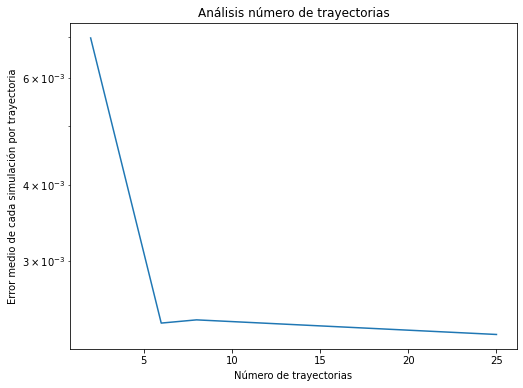

In [14]:
# aprox taylor grado 2
n_trayectorias_test = [2,6,8, 25]
n_sims = N_SIMS
len_traj = t.shape[0]
v0 = 5

error = np.zeros((n_sims, len(n_trayectorias_test), len_traj)) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC2, n_trayectorias_test[i], t, [T0, A, B], v0,
                    mod=utils.Model_params(lib=ps.PolynomialLibrary(degree=2), opt=1, feature_list=['v']), )
        error[j,i] = mod.error_trayec(t)[:, 0]

    if n_trayectorias_test[i] == 25:
        #mod.plot_trayec(t)
        model25 = mod.model_sindy
model25.print(lhs=["v'"])
# Representar
plot_ntraj(n_trayectorias_test, error)

In [17]:
# aprox taylor grado 3
n_trayectorias_test = [2,4,6,8,10, 25]
n_sims = 2 #N_SIMS
len_traj = t.shape[0]
v0 = 5

n_features, data, _ = initial_vars()

models = [None, 
        utils.Model_params(deltat=deltat, initial_guess=np.ones((data[0].shape[1], n_features)), 
        lib=ps.PolynomialLibrary(degree=3), opt=1, feature_list=['v'])]
error2 = np.zeros((n_sims, len(n_trayectorias_test), len_traj)) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC2, n_trayectorias_test[i], t, [T0, A, B], v0, 
                        mod=utils.Model_params(lib=ps.PolynomialLibrary(degree=3),feature_list=['v']))
        error2[j,i] = mod.error_trayec(t)[:, 0]
    if n_trayectorias_test[i] == 25:
        mod.plot_trayec(t)
        model25 = mod.model_sindy

model25.print(lhs=["v'"])

# Representar
plot_ntraj(n_trayectorias_test, error2)


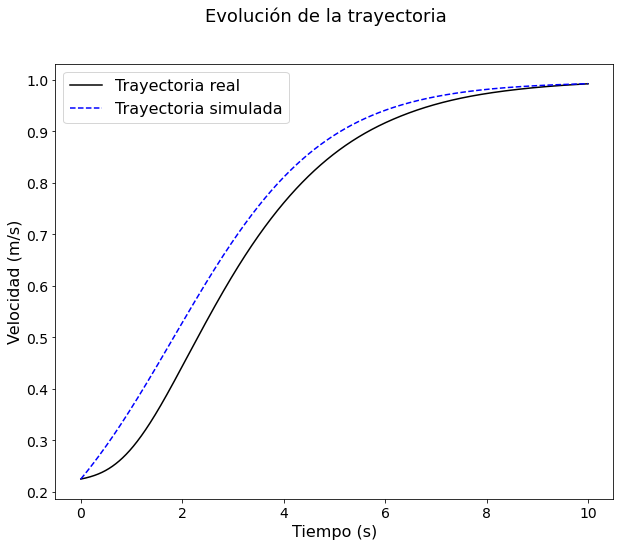

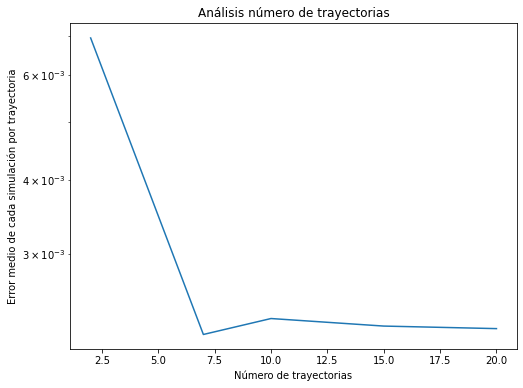

In [13]:
# aprox taylor grado 2
n_trayectorias_test = [2,4,6,7,8,10,15,17,20]
n_trayectorias_test = [2,7,10,15,20]

n_sims = N_SIMS
len_traj = t.shape[0]
v0 = 5

t2 = np.arange(0, int(n*3*deltat), deltat)

error3 = np.zeros((n_sims, len(n_trayectorias_test), len_traj))
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC2, n_trayectorias_test[i], t, [T0, A, B], v0, 
                                        mod=utils.Model_params(lib=ps.PolynomialLibrary(degree=2)))
        error3[j,i] = mod.error_trayec(t)[:, 0]
mod.plot_trayec(t)
# Representar
plot_ntraj(n_trayectorias_test, error3)

/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


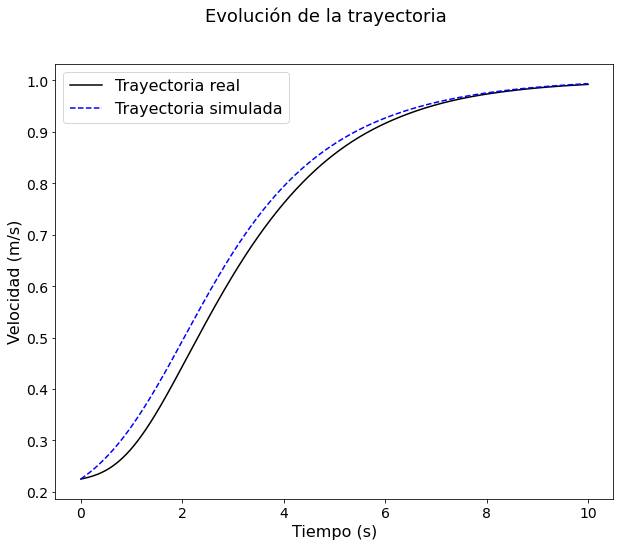

In [14]:
# aprox taylor grado 3
n_trayectorias_test = [2,4,6,7,8,10,15,17,20]
n_trayectorias_test = [2,7,10,15,20]

n_sims = N_SIMS
len_traj = t.shape[0]
v0 = 5

t2 = np.arange(0, int(n*3*deltat), deltat)

error4 = np.zeros((n_sims, len(n_trayectorias_test), len_traj))
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC2, n_trayectorias_test[i], t, [T0, A, B], v0)
        error4[j,i] = mod.error_trayec(t)[:, 0]
mod.plot_trayec(t)


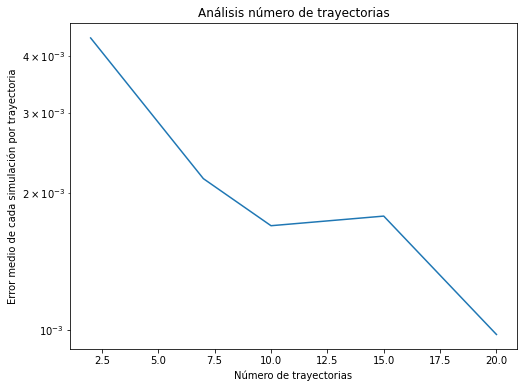

In [15]:
# Representar
plot_ntraj(n_trayectorias_test, error4)

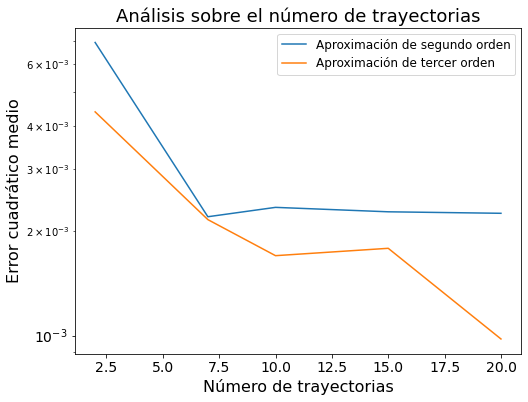

In [37]:
plt.figure(figsize=(8,6))
plt.title("Análisis sobre el número de trayectorias", fontsize=18)
plt.xlabel('Número de trayectorias', fontsize=16)
plt.ylabel('Error cuadrático medio', fontsize=16)
plt.semilogy(n_trayectorias_test, np.median(np.mean(error3, axis=2), axis=0), label='Aproximación de segundo orden')
plt.semilogy(n_trayectorias_test, np.median(np.mean(error4, axis=2), axis=0), label='Aproximación de tercer orden')
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

In [13]:
#Aprox taylor grado 2
# represento la evoucion del error con el tiempo
n_trayectorias_test = [1, 2, 3, 5, 10, 15, 25]
n_sims = N_SIMS
lent = t.shape[0]
v0 = 5
# t vs error en cada punto
error5 = np.zeros((n_sims, len(n_trayectorias_test), lent)) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC2, n_trayectorias_test[i], t, [T0, A, B], v0, 
                                mod=utils.Model_params(lib=ps.PolynomialLibrary(degree=2)))
        error5[j,i] = mod.error_trayec(t)[:, 0]
mod.plot_trayec(t)
 
# Representar
plot_error_vs_tiempo(t, error5, n_trayectorias_test)

/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


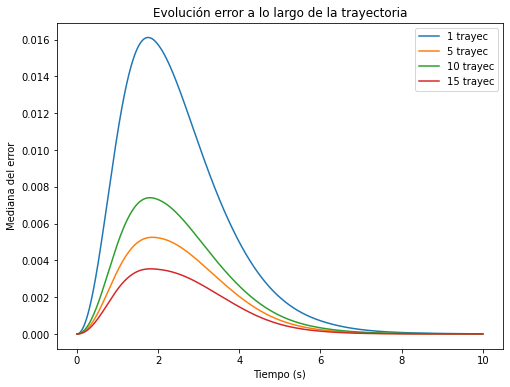

In [15]:
#Aprox taylor grado 3
# represento la evoucion del error con el tiempo
n_trayectorias_test = [1, 2, 3, 5, 10, 15, 25]
n_sims = N_SIMS
lent = t.shape[0]
v0 = 5
# t vs error en cada punto
error6 = np.zeros((n_sims, len(n_trayectorias_test), lent)) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC2, n_trayectorias_test[i], t, [T0, A, B], v0)
        error6[j,i] = mod.error_trayec(t)[:, 0]
mod.plot_trayec(t)
 
# Representar
plot_error_vs_tiempo(t, error6, n_trayectorias_test)

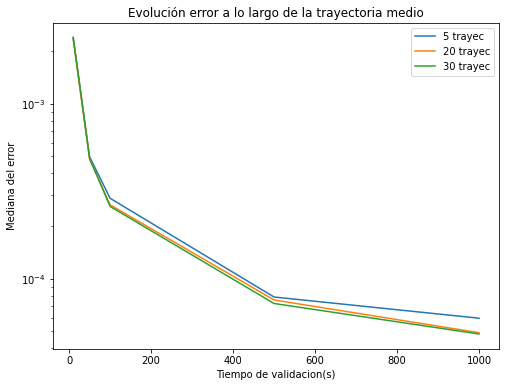

In [12]:
# entreno con t y calculo el error para tiempos mas grandes
# grado 2
n_trayec = [5, 20, 30]
n_sims = N_SIMS
tiempos_val = [10, 50, 100, 500, 1000]
v0 = 5
# t_train vs error en cada punto
error7 = np.zeros((n_sims, len(n_trayec), len(tiempos_val))) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayec)):
    for z in range(len(tiempos_val)):
        t_val = np.arange(0, tiempos_val[z], deltat)
        for j in range(n_sims):
            mod = utils.Model()
            mod.eval(utils.casoC2, n_trayec[i], t, [T0, A, B], v0, t_val=t_val,
                     mod=utils.Model_params(lib=ps.PolynomialLibrary(degree=2)))
            error7[j,i,z] = mod.error_trayec(t_val)[:, 0].mean()

# Representar tiempo de val vs error
plot_error_vs_tiempo_val(tiempos_val, error7, n_trayec)


In [13]:
# entreno con t y calculo el error para tiempos mas grandes
# grado 3
n_trayec = [5, 20, 30]
n_sims = N_SIMS
tiempos_val = [10, 50, 100, 500, 1000]
v0 = 5
# t_train vs error en cada punto
error8 = np.zeros((n_sims, len(n_trayec), len(tiempos_val))) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayec)):
    for z in range(len(tiempos_val)):
        t_val = np.arange(0, tiempos_val[z], deltat)
        for j in range(n_sims):
            mod = utils.Model()
            mod.eval(utils.casoC2, n_trayec[i], t, [T0, A, B], v0, t_val=t_val)
            error8[j,i,z] = mod.error_trayec(t_val)[:, 0].mean()



/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


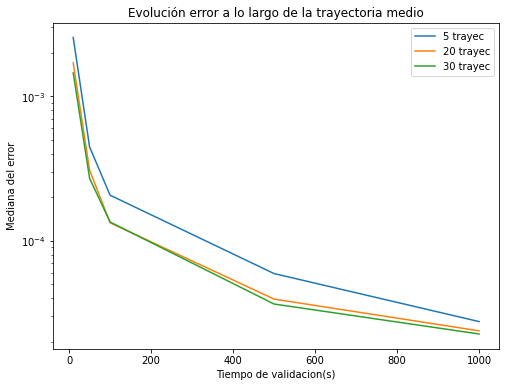

In [14]:
# Representar tiempo de val vs error. 
plot_error_vs_tiempo_val(tiempos_val, error8, n_trayec)

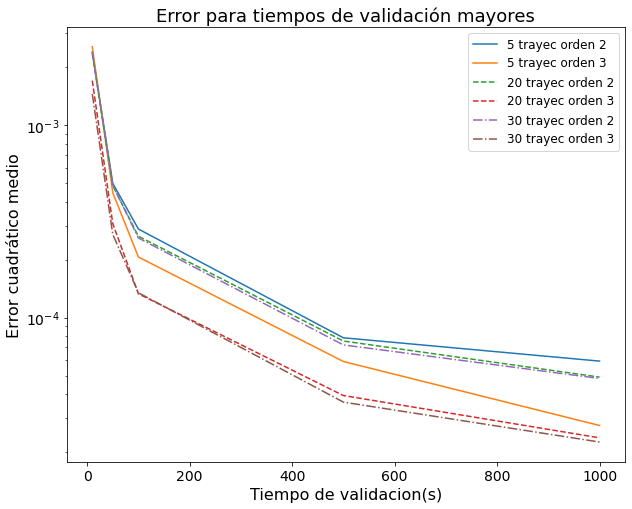

In [17]:
lines = ['-', '--', '-.']
plt.figure(figsize=(10,8))
plt.title("Error para tiempos de validación mayores", fontsize=18)
plt.xlabel('Tiempo de validacion(s)', fontsize=16)
plt.ylabel('Error cuadrático medio', fontsize=16)
error7_1 = np.median(error7, axis=0)
error8_1 = np.median(error8, axis=0)
for trayec, i in zip(n_trayec, range(len(n_trayec))):
    plt.semilogy(tiempos_val, error7_1[i, :], lines[i], label=str(trayec)+ ' trayec orden 2')
    plt.semilogy(tiempos_val, error8_1[i, :], lines[i], label=str(trayec)+ ' trayec orden 3')
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

In [16]:
# obtengo el error con ruido en las muestras REVISAR
# grado 3
n_trayec = [10, 15]
n_sims = N_SIMS
tiempos_val = [10, 50, 100, 500, 1000]
v0 = 5
# t_train vs error en cada punto
error9 = np.zeros((n_sims, len(n_trayec), len(tiempos_val))) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayec)):
    for z in range(len(tiempos_val)):
        t_val = np.arange(0, tiempos_val[z], deltat)
        for j in range(n_sims):
            mod = utils.Model()
            mod.eval(utils.casoC2, n_trayec[i], t, [T0, A, B], v0, t_val=t_val, ruido=0.1)
            error9[j,i,z] = mod.error_trayec(t_val)[:, 0].mean()



/home/mdiaz/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

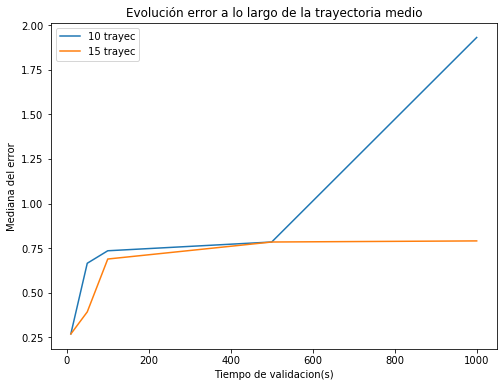

In [ ]:
# Representar tiempo de val vs error con ruido  
plot_error_vs_tiempo_val(tiempos_val, error9, n_trayec)

In [ ]:
# obtengo el error con ruido en las muestras de train
n_trayec = [5, 10, 15, 20]
n_sims = 20
v0 = 5
# t_train vs error en cada punto
error10 = np.zeros((n_sims, len(n_trayec), t.shape[0]))
for i in range(len(n_trayec)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC2, n_trayec[i], t, [T0, A, B], v0, ruido=0.01)
        error10[j,i] = mod.error_trayec(t)[:, 0]
           
# Representar tiempo de val vs error con ruido  
plot_error_vs_tiempo(t, error10, n_trayec)

In [ ]:
# obtengo el error con ruido en las muestras
n_trayec = [5, 10, 15]
n_sims = N_SIMS
v0 = 5
# t_train vs error en cada punto
error11 = np.zeros((n_sims, len(n_trayec), t.shape[0]))
for i in range(len(n_trayec)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC2, n_trayec[i], t, [T0, A, B], v0, ruido=0.003)
        error11[j,i,:] = mod.error_trayec(t)[: ,0]
            
# Representar tiempo de val vs error con ruido  
plot_error_vs_tiempo(t, error11, n_trayec)

In [11]:
# error vs potencia de ruido en las muestras

n_trayec = [5, 10, 15]
n_sims = N_SIMS
v0 = 5
pots_ruido = [1e-4, 1e-3, 1e-2, 1e-1]
# t_train vs error en cada punto
error12 = np.zeros((n_sims, len(n_trayec), len(pots_ruido)))
for i in range(len(n_trayec)):
    for j in range(n_sims):
        for z in range(len(pots_ruido)):
            mod = utils.Model()
            mod.eval(utils.casoC2, n_trayec[i], t, [T0, A, B], v0, ruido=pots_ruido[z])
            error12[j,i,z] = mod.error_trayec(t)[:, 0].mean()
            
# Representar tiempo de val vs error con ruido  
plot_error_vs_pot_ruido(error12, n_trayec, pots_ruido)

/home/mdiaz/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

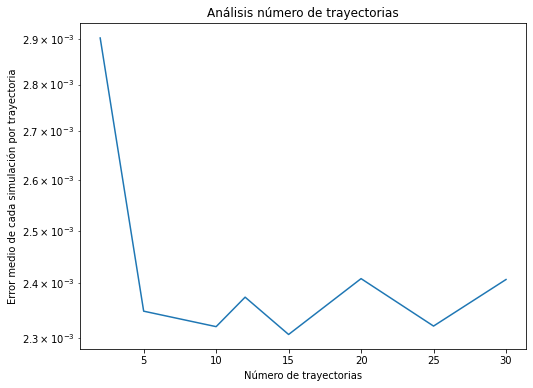

In [24]:

lib = ps.PolynomialLibrary(degree=2)
n_trayec = [2, 5, 10, 12, 15, 20, 25, 30]
n_sims = N_SIMS
v0 = 5
deltat_train = t[1]-t[0]

errors_pol = []
error_pol = np.zeros((n_sims, len(n_trayec), n))

for i in range(len(n_trayec)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC2, n_trayec[i], t, [T0, A, B], v0, mod=utils.Model_params(lib=lib))
        error_pol[j,i, :] = mod.error_trayec(t)[: ,0]
         

            
# Representar tiempo de val vs error con ruido  
plot_ntraj(n_trayec, error_pol)


In [25]:
# calculo el error según el tamaño de t de train y el numero de muestras
n_sims = N_SIMS
tiempos_train = [10, 50, 100, 500, 1000]
muestras = [10**4, 10**5, 10**6]
v0 = 5
# t_train vs error en cada punto
error13 = np.zeros((n_sims, len(muestras), len(tiempos_train)))
for i in range(len(muestras)):
    for z in range(len(tiempos_train)):
        t_train = np.arange(0, tiempos_train[z], deltat)
        for j in range(n_sims):
            mod = utils.Model()
            mod.eval(utils.casoC2, n_trayec[i], t_train, [T0, A, B], v0)
            error13[j,i,z] = mod.error_trayec(t_train)[:, 0].mean()

/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
/home/mdia

(3, 5)
(3, 5) (3, 5)


<ipython-input-33-8951483ecf30>:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


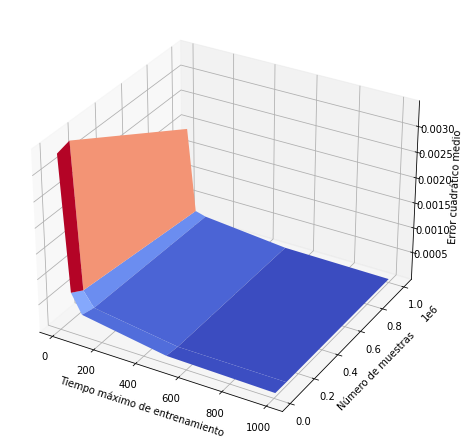

In [34]:
plot_precision_tiempo(error13, muestras, tiempos_train)

In [12]:
def real_coefs_mat(real_coefs):
    data = [np.ones((n, 1))]
    lib = utils.custom_ecs_B().fit(data[0])
    n_features = lib.n_output_features_
    list_names = lib.get_feature_names(['v'])

    mat = np.zeros((data[0].shape[1], n_features))
    mat[0, list_names.index('v^2')] = real_coefs[0]
    mat[0, list_names.index('1/v^2')] = real_coefs[1]
    mat[0, list_names.index('1')] = real_coefs[2]

    return mat


In [ ]:
# error en los coeficientes según el número de trayectorias:
""" n_trayectorias_test = [2,4,6,8,10,13, 15, 20]
n_sims = N_SIMS
len_traj = t.shape[0]
v0 = 5


error14 = np.zeros((n_sims, len(n_trayectorias_test)))
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoC2, n_trayectorias_test[i], t, [T0, A, B], v0, print_model=True,
                mod=utils.Model_params(lib=ps.PolynomialLibrary(degree=2)))
        real_coefs = np.array([-A*mod.maxi, -B/mod.maxi**3, T0/mod.maxi])
        mat_real = real_coefs_mat(real_coefs)
        error14[j, i] = np.mean(mod.error_coefs(mat_real)**2)
        

# Representar
plot_ntraj(n_trayectorias_test, error14) """